## Read in Data and Preview

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
panel_data = pd.read_excel('../data/DSA3101_Hackathon_Panelists_Demographics.xlsx') 
cat_data = pd.read_csv('../data/DSA3101_Hackathon_Categories_Information.csv')
data = pd.read_csv('../data/DSA3101_Hackathon_Data.csv')

In [222]:
panel_data.head()

,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North


In [223]:
data.isnull().sum()
#cat_data.isnull().sum()
#panel_data.isnull().sum()

Panel ID     0
Date         0
Category     0
Pack Size    0
Volume       0
Spend        0
dtype: int64

In [224]:
data.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [225]:
panelist = list(data['Panel ID'].unique())
len(panelist)

3236

In [226]:
# When rerun use this csv to make result consistent
seg_data2 = pd.read_csv("../data/food_basket.csv")

In [227]:
seg_data2[seg_data2['Clusters']==1]

,Category,Calories/100g,Price per Volume,Clusters
5,Bouilon,0.02000,0.327256,1
16,Coffee,0.00125,0.300706,1
31,Ghee,0.15000,0.497607,1
41,Milk Powder-Adult,0.07250,0.359503,1
43,Milk Powder-Kids,0.07750,0.383546,1
44,MSG,0.00000,0.212511,1
56,Tea,0.00125,0.436531,1


## Decision tree after clustering products into basket

In [228]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_auc_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split

### Product basket 0

In [229]:
# Based on which product group
product_0 = seg_data2[seg_data2['Clusters']==0].Category
list(product_0)

['Baby Cereal',
 'Biscuits',
 'Cake',
 'Canned Product',
 'Cereal Beverage',
 'Cereals',
 'Cheese',
 'Coconut Milk',
 'Condensed/Evap Milk',
 'Confectionery',
 'Cooking Sauces',
 'Cordials',
 'Creamer',
 'Flour',
 'Frozen Food',
 'Honey',
 'Ice Cream',
 'Instant Noodles',
 'Instant Soup',
 'Jam',
 'Kaya',
 'Rice',
 'Salad Dressing',
 'Savoury Spread',
 'Seasoning Powder',
 'Snack',
 'Spagetti',
 'Sugar']

In [230]:
data_for_model = data.groupby(['Panel ID','Category']).agg({'Spend': lambda x : x.sum()}).reset_index()

In [231]:
cat_data.reset_index(drop=True, inplace=True)
cat_data.head()

,Category,Calories/100g,Price per Volume
0,Baby Cereal,188,29.41
1,Beer,43,15.12
2,Belacan,563,39.47
3,Bird Nest,46,73.45
4,Biscuits,416,15.57


In [232]:
data_for_model_full = cat_data.merge(data_for_model, how='outer')

In [233]:
data_for_model_full.head()

,Category,Calories/100g,Price per Volume,Panel ID,Spend
0,Baby Cereal,188,29.41,Panel 105044101,10.3
1,Baby Cereal,188,29.41,Panel 105052101,23.2
2,Baby Cereal,188,29.41,Panel 106077101,40.8
3,Baby Cereal,188,29.41,Panel 107009103,9.9
4,Baby Cereal,188,29.41,Panel 107030101,14.2


In [234]:
data_full_0 = data_for_model_full[data_for_model_full['Category'].isin(product_0)]
data_full_0

,Category,Calories/100g,Price per Volume,Panel ID,Spend
0,Baby Cereal,188,29.41,Panel 105044101,10.3
1,Baby Cereal,188,29.41,Panel 105052101,23.2
2,Baby Cereal,188,29.41,Panel 106077101,40.8
3,Baby Cereal,188,29.41,Panel 107009103,9.9
4,Baby Cereal,188,29.41,Panel 107030101,14.2
...,...,...,...,...,...
89286,Sugar,405,2.94,Panel 801893001,37.1
89287,Sugar,405,2.94,Panel 801899801,37.3
89288,Sugar,405,2.94,Panel 801901201,16.9
89289,Sugar,405,2.94,Panel 801903801,2.8


In [235]:
data_full_0 = data_full_0.groupby('Panel ID').agg({'Spend': lambda x : x.sum()}).reset_index()
data_full_0.head()

,Panel ID,Spend
0,Panel 101011101,2728.0
1,Panel 101016101,1307.8
2,Panel 101019101,3867.4
3,Panel 101024101,3778.9
4,Panel 105009103,2333.5


In [236]:
data_full_0 = data_full_0.merge(pd.DataFrame(panelist, columns = ['Panel ID']), how = "outer").fillna(0)
data_full_0.head()

,Panel ID,Spend
0,Panel 101011101,2728.0
1,Panel 101016101,1307.8
2,Panel 101019101,3867.4
3,Panel 101024101,3778.9
4,Panel 105009103,2333.5


In [237]:
spend_group = data_full_0['Spend'].quantile([ .25,.3, .5,.75])   
print(spend_group)

0.25     512.475
0.30     688.700
0.50    1552.900
0.75    3002.775
Name: Spend, dtype: float64


In [238]:
# if the spending satisfies some certain criteria (like <0.3 quantile, based on different basket),
# than assign to be not buying(1);
# otherwise, assign to buying(0)
data_full_0['Spend'].values[data_full_0['Spend'].values<=spend_group[0.3]]=0
data_full_0['Spend'].values[data_full_0['Spend'].values>spend_group[0.3]]=1
data_full_0

,Panel ID,Spend
0,Panel 101011101,1.0
1,Panel 101016101,1.0
2,Panel 101019101,1.0
3,Panel 101024101,1.0
4,Panel 105009103,1.0
...,...,...
3231,Panel 801903801,0.0
3232,Panel 801912801,0.0
3233,Panel 800063501,0.0
3234,Panel 800421501,0.0


In [239]:
len(data_full_0[data_full_0['Spend']==0].Spend)

971

In [240]:
overall0 = data_full_0.merge(panel_data,left_on='Panel ID', right_on='ID')
overall0.drop(['ID'],axis=1,inplace=True)
overall0 = overall0[['Panel ID','BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location","Spend"]]
overall0

,Panel ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,Spend
0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,1.0
1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,1.0
2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,1.0
3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,1.0
4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,1.0
...,...,...,...,...,...,...,...,...,...
3231,Panel 801903801,Healthy,Income 1500 - 1999,Central Malay,Yankys,Urban,1-3 Member HH,Central,0.0
3232,Panel 801912801,Obese,Income 2000 - 2999,East Coast Malay,Teens Aches,Urban,5 Member HH,East Coast,0.0
3233,Panel 800063501,Under Weight,Income 3000 - 3999,East Coast Malay,Nesting Families,Urban,4 Member HH,East Coast,0.0
3234,Panel 800421501,Under Weight,Income 4000 - 4999,Central Chinese,Nesting Families,Urban,1-3 Member HH,Central,0.0


In [241]:
X = overall0.drop('Spend',1)
y = overall0.Spend

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=8)

In [243]:
X_test_id = X_test['Panel ID']

In [244]:
#Remove the id column
X_train = X_train.drop(columns=['Panel ID'])
X_test = X_test.drop(columns=['Panel ID'])

In [245]:
X_test.columns

Index(['BMI', 'Income', 'Ethnicity', 'Lifestage', 'Strata', '#HH', 'location'], dtype='object')

In [246]:
X_train = pd.get_dummies(X_train, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])
X_test = pd.get_dummies(X_test, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])

In [247]:
X_test.columns

Index(['BMI_Healthy', 'BMI_Obese', 'BMI_Over Weight', 'BMI_Under Weight',
       'Income_Income 1500 - 1999', 'Income_Income 2000 - 2999',
       'Income_Income 3000 - 3999', 'Income_Income 4000 - 4999',
       'Income_Income < 1500', 'Income_Income >5000',
       'Ethnicity_Central Chinese', 'Ethnicity_Central Malay',
       'Ethnicity_Central Others', 'Ethnicity_East Coast Chinese',
       'Ethnicity_East Coast Malay', 'Ethnicity_East Coast Others',
       'Ethnicity_North Chinese', 'Ethnicity_North Malay',
       'Ethnicity_North Others', 'Ethnicity_South Chinese',
       'Ethnicity_South Malay', 'Ethnicity_South Others',
       'Lifestage_Empty Nesters', 'Lifestage_Matured Families',
       'Lifestage_Nesting Families', 'Lifestage_Teens Aches',
       'Lifestage_Teens and Toddlers', 'Lifestage_Yankys', 'Strata_Rural',
       'Strata_Urban', '#HH_1-3 Member HH', '#HH_4 Member HH',
       '#HH_5 Member HH', '#HH_6 Member HH', '#HH_7+ Member HH',
       'location_Central', 'location_E

In [248]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [249]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=8)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [250]:
print(clf.get_n_leaves())
print(clf.get_depth())
print(clf.get_params())

839
23
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 8, 'splitter': 'best'}


In [251]:
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(10, 100, num = 90)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt']

In [252]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,118,218
Predicted Y=1,168,467


Accuracy: 0.6025
Specificity: 0.4126
Sensitivity 0.6818
F1-Score: 0.7076
AUC: 0.5472


[('Lifestage_Nesting Families', 0.06),
 ('#HH_5 Member HH', 0.055),
 ('Income_Income >5000', 0.043),
 ('#HH_7+ Member HH', 0.043),
 ('Income_Income 2000 - 2999', 0.04),
 ('#HH_4 Member HH', 0.04),
 ('Income_Income < 1500', 0.038),
 ('BMI_Under Weight', 0.037),
 ('#HH_6 Member HH', 0.037),
 ('Income_Income 1500 - 1999', 0.036),
 ('Strata_Urban', 0.036),
 ('Income_Income 3000 - 3999', 0.034),
 ('Ethnicity_North Malay', 0.034),
 ('Strata_Rural', 0.034),
 ('Income_Income 4000 - 4999', 0.031),
 ('BMI_Obese', 0.03),
 ('BMI_Healthy', 0.029),
 ('Ethnicity_South Malay', 0.029),
 ('#HH_1-3 Member HH', 0.029),
 ('BMI_Over Weight', 0.026),
 ('Lifestage_Matured Families', 0.023),
 ('Lifestage_Teens Aches', 0.023),
 ('Ethnicity_North Chinese', 0.022),
 ('Lifestage_Teens and Toddlers', 0.02),
 ('location_North', 0.019),
 ('Lifestage_Yankys', 0.018),
 ('Ethnicity_East Coast Malay', 0.016),
 ('Ethnicity_South Chinese', 0.016),
 ('Ethnicity_Central Malay', 0.015),
 ('Ethnicity_Central Others', 0.013),
 

Best max_depth for gini: 4
Best max_depth for entropy: 3


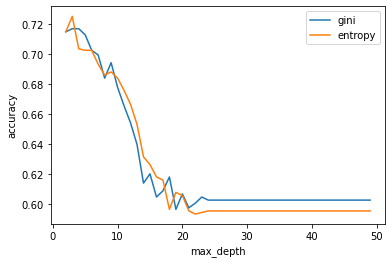

In [253]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(2,50):
    dtree = DecisionTreeClassifier(random_state=8,criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    ###
    dtree = DecisionTreeClassifier(random_state=8,criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')

plt.legend()
plt.savefig("pruning.png")
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

In [254]:
print(d.sort_values('acc_entropy',ascending=False)[0:5])

   acc_gini  acc_entropy  max_depth
1  0.716787     0.725026          3
0  0.714727     0.714727          2
2  0.716787     0.703399          4
3  0.712667     0.702369          5
4  0.702369     0.702369          6


In [255]:
clf2 = DecisionTreeClassifier(random_state=8,max_depth=3,criterion='entropy')
clf2 = clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)

In [256]:
from sklearn.metrics import precision_score

In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve
pd.set_option("display.max_rows", None, "display.max_columns", None)
import math

In [257]:
cm2 = pd.DataFrame(confusion_matrix(y_pred2, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy:", round(accuracy_score(y_test, y_pred2),4))
print('Precision:',round(precision_score(y_test, y_pred2),4))
print('Specificity:', round(specificity2,4))
print('Sensitivity', round(recall_score(y_test,y_pred2),4))
print('F1-Score:',  round(f1_score(y_test,y_pred2),4))
print('AUC:', round(roc_auc_score(y_test, y_pred2),4))
feature_imp(clf2)

,True Y=0,True Y=1
Predicted Y=0,56,37
Predicted Y=1,230,648


Accuracy: 0.725
Precision: 0.738
Specificity: 0.1958
Sensitivity 0.946
F1-Score: 0.8292
AUC: 0.5709


[('Lifestage_Nesting Families', 0.48),
 ('BMI_Under Weight', 0.305),
 ('Lifestage_Yankys', 0.149),
 ('Income_Income >5000', 0.065)]

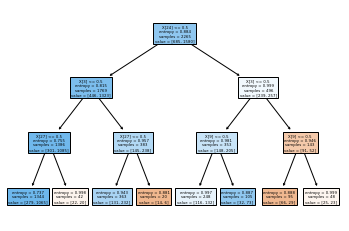

In [258]:
plt.figure()
tree.plot_tree(clf2,filled=True)  
plt.savefig('product_0_decisiontree.eps',format='eps',bbox_inches = "tight") #save trees using different groups

In [259]:
dotfile = open("tree.dot", 'w')
tree.export_graphviz(clf2,out_file = dotfile,
                     feature_names=X_test.columns,
                     class_names = [str(i) for i in clf2.classes_],
                     proportion=False) 
dotfile.close()

In [274]:
X_train.columns

Index(['BMI_Healthy', 'BMI_Obese', 'BMI_Over Weight', 'BMI_Under Weight',
       'Income_Income 1500 - 1999', 'Income_Income 2000 - 2999',
       'Income_Income 3000 - 3999', 'Income_Income 4000 - 4999',
       'Income_Income < 1500', 'Income_Income >5000',
       'Ethnicity_Central Chinese', 'Ethnicity_Central Malay',
       'Ethnicity_Central Others', 'Ethnicity_East Coast Chinese',
       'Ethnicity_East Coast Malay', 'Ethnicity_East Coast Others',
       'Ethnicity_North Chinese', 'Ethnicity_North Malay',
       'Ethnicity_North Others', 'Ethnicity_South Chinese',
       'Ethnicity_South Malay', 'Ethnicity_South Others',
       'Lifestage_Empty Nesters', 'Lifestage_Matured Families',
       'Lifestage_Nesting Families', 'Lifestage_Teens Aches',
       'Lifestage_Teens and Toddlers', 'Lifestage_Yankys', 'Strata_Rural',
       'Strata_Urban', '#HH_1-3 Member HH', '#HH_4 Member HH',
       '#HH_5 Member HH', '#HH_6 Member HH', '#HH_7+ Member HH',
       'location_Central', 'location_E

In [275]:
#logistic regression
all_predictors = "+".join(X_train.columns)
print(all_predictors)

BMI_Healthy+BMI_Obese+BMI_Over Weight+BMI_Under Weight+Income_Income 1500 - 1999+Income_Income 2000 - 2999+Income_Income 3000 - 3999+Income_Income 4000 - 4999+Income_Income < 1500+Income_Income >5000+Ethnicity_Central Chinese+Ethnicity_Central Malay+Ethnicity_Central Others+Ethnicity_East Coast Chinese+Ethnicity_East Coast Malay+Ethnicity_East Coast Others+Ethnicity_North Chinese+Ethnicity_North Malay+Ethnicity_North Others+Ethnicity_South Chinese+Ethnicity_South Malay+Ethnicity_South Others+Lifestage_Empty Nesters+Lifestage_Matured Families+Lifestage_Nesting Families+Lifestage_Teens Aches+Lifestage_Teens and Toddlers+Lifestage_Yankys+Strata_Rural+Strata_Urban+#HH_1-3 Member HH+#HH_4 Member HH+#HH_5 Member HH+#HH_6 Member HH+#HH_7+ Member HH+location_Central+location_East Coast+location_North+location_South


### Using RFM Clustering Groups for Result Analysis (Basket 0)

In [260]:
labelled_data = pd.read_csv("../data/RFM_group.csv")
labelled_data.head()

,Unnamed: 0,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,F_change,M_change,status
0,0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,0.0,0.0,Normal
1,1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,0.0,-1.0,Normal
2,2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,0.0,0.0,Loyal
3,3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,0.0,0.0,Loyal
4,4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,0.0,0.0,Normal


In [261]:
test_df = pd.DataFrame({'ID':X_test_id, 'true':y_test})
test_df = test_df.merge(labelled_data[['ID','status']], left_on ='ID', right_on='ID', how = 'left')
test_df.head()

,ID,true,status
0,Panel 224100101,1.0,Normal
1,Panel 800551901,0.0,Churned
2,Panel 800266801,1.0,Normal
3,Panel 801567701,0.0,Normal
4,Panel 109029101,1.0,Normal


In [262]:
test_df['pred']=y_pred2
test_df.head()

,ID,true,status,pred
0,Panel 224100101,1.0,Normal,1.0
1,Panel 800551901,0.0,Churned,0.0
2,Panel 800266801,1.0,Normal,1.0
3,Panel 801567701,0.0,Normal,1.0
4,Panel 109029101,1.0,Normal,1.0


In [219]:
for status in ["Improving","Loyal","Normal","Churning"]:
    cm2 = pd.DataFrame(confusion_matrix(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']))
    cm2.columns = ['True Y=0','True Y=1']
    cm2.index = ['Predicted Y=0','Predicted Y=1']
    display(cm2)
    print(f"Accuracy for {status}:",round(accuracy_score(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']),4))
    

,True Y=0,True Y=1
Predicted Y=0,0,1
Predicted Y=1,21,49


Accuracy for Improving: 0.6901


,True Y=0,True Y=1
Predicted Y=0,1,2
Predicted Y=1,3,160


Accuracy for Loyal: 0.9699


,True Y=0,True Y=1
Predicted Y=0,7,12
Predicted Y=1,134,341


Accuracy for Normal: 0.7045


,True Y=0,True Y=1
Predicted Y=0,3,3
Predicted Y=1,28,62


Accuracy for Churning: 0.6771


### Product basket 1

In [44]:
# Based on which product group(7 groups in total)
product_1 = seg_data2[seg_data2['Clusters']==1].Category
list(product_1)

['Bouilon',
 'Coffee',
 'Ghee',
 'Milk Powder-Adult',
 'Milk Powder-Kids',
 'MSG',
 'Tea']

In [45]:
data_for_model = data.groupby(['Panel ID','Category']).agg({'Spend': lambda x : x.sum()}).reset_index()

In [46]:
cat_data.reset_index(drop=True, inplace=True)
cat_data.head()

,Category,Calories/100g,Price per Volume
0,Baby Cereal,188,29.41
1,Beer,43,15.12
2,Belacan,563,39.47
3,Bird Nest,46,73.45
4,Biscuits,416,15.57


In [47]:
data_for_model_full = cat_data.merge(data_for_model, how='outer')

In [48]:
data_for_model_full.head()

,Category,Calories/100g,Price per Volume,Panel ID,Spend
0,Baby Cereal,188,29.41,Panel 105044101,10.3
1,Baby Cereal,188,29.41,Panel 105052101,23.2
2,Baby Cereal,188,29.41,Panel 106077101,40.8
3,Baby Cereal,188,29.41,Panel 107009103,9.9
4,Baby Cereal,188,29.41,Panel 107030101,14.2


In [49]:
data_full_1 = data_for_model_full[data_for_model_full['Category'].isin(product_1)]
data_full_1

,Category,Calories/100g,Price per Volume,Panel ID,Spend
4545,Bouilon,16,29.09,Panel 101011101,15.4
4546,Bouilon,16,29.09,Panel 101016101,38.5
4547,Bouilon,16,29.09,Panel 101024101,11.5
4548,Bouilon,16,29.09,Panel 105009103,24.4
4549,Bouilon,16,29.09,Panel 105021106,201.0
...,...,...,...,...,...
91587,Tea,1,38.68,Panel 801874701,4.9
91588,Tea,1,38.68,Panel 801893001,54.0
91589,Tea,1,38.68,Panel 801899801,5.5
91590,Tea,1,38.68,Panel 801903201,39.6


In [50]:
data_full_1 = data_full_1.groupby('Panel ID').agg({'Spend': lambda x : x.sum()}).reset_index()
data_full_1.head()

,Panel ID,Spend
0,Panel 101011101,185.4
1,Panel 101016101,124.7
2,Panel 101019101,1657.4
3,Panel 101024101,414.8
4,Panel 105009103,655.7


In [51]:
data_full_1 = data_full_1.merge(pd.DataFrame(panelist, columns = ['Panel ID']), how = "outer").fillna(0)
data_full_1.head()

,Panel ID,Spend
0,Panel 101011101,185.4
1,Panel 101016101,124.7
2,Panel 101019101,1657.4
3,Panel 101024101,414.8
4,Panel 105009103,655.7


In [52]:
spend_group = data_full_1['Spend'].quantile([ .25,.3, .5,.75])   
print(spend_group)

0.25     76.700
0.30    108.400
0.50    295.150
0.75    786.925
Name: Spend, dtype: float64


In [53]:
# if the spending satisfies some certain criteria (like <0.3 quantile, based on different basket),
# than assign to be not buying(1);
# otherwise, assign to buying(0)
data_full_1['Spend'].values[data_full_1['Spend'].values<=spend_group[0.3]]=0
data_full_1['Spend'].values[data_full_1['Spend'].values>spend_group[0.3]]=1
data_full_1

,Panel ID,Spend
0,Panel 101011101,1.0
1,Panel 101016101,1.0
2,Panel 101019101,1.0
3,Panel 101024101,1.0
4,Panel 105009103,1.0
...,...,...
3231,Panel 801791301,0.0
3232,Panel 801820401,0.0
3233,Panel 801820701,0.0
3234,Panel 801820901,0.0


In [54]:
len(data_full_1[data_full_1['Spend']==0].Spend)

971

In [55]:
overall1 = data_full_1.merge(panel_data,left_on='Panel ID', right_on='ID')
overall1.drop(['ID'],axis=1,inplace=True)
overall1

,Panel ID,Spend,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,1.0,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,1.0,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,1.0,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,1.0,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,1.0,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North
...,...,...,...,...,...,...,...,...,...
3231,Panel 801791301,0.0,Obese,Income >5000,South Malay,Teens and Toddlers,Urban,6 Member HH,South
3232,Panel 801820401,0.0,Healthy,Income 3000 - 3999,East Coast Malay,Nesting Families,Rural,4 Member HH,East Coast
3233,Panel 801820701,0.0,Under Weight,Income 3000 - 3999,Central Malay,Yankys,Urban,1-3 Member HH,Central
3234,Panel 801820901,0.0,Healthy,Income 3000 - 3999,North Malay,Nesting Families,Rural,7+ Member HH,North


In [56]:
X = overall1.drop('Spend',1)
y = overall1.Spend

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=8)

In [58]:
X_test_id = X_test['Panel ID']

In [59]:
#Remove the id column
X_train = X_train.drop(columns=['Panel ID'])
X_test = X_test.drop(columns=['Panel ID'])

In [60]:
X_test.columns

Index(['BMI', 'Income', 'Ethnicity', 'Lifestage', 'Strata', '#HH', 'location'], dtype='object')

In [61]:
X_train = pd.get_dummies(X_train, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])
X_test = pd.get_dummies(X_test, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])

In [62]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [63]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=8)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [64]:
print(clf.get_n_leaves())
print(clf.get_depth())
print(clf.get_params())

851
27
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 8, 'splitter': 'best'}


In [65]:
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(10, 100, num = 90)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt']

In [66]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,100,206
Predicted Y=1,170,495


Accuracy: 0.6128
Specificity: 0.3704
Sensitivity 0.7061
F1-Score: 0.7247
AUC: 0.5383


[('#HH_4 Member HH', 0.051),
 ('Lifestage_Nesting Families', 0.05),
 ('#HH_1-3 Member HH', 0.046),
 ('Lifestage_Teens and Toddlers', 0.045),
 ('#HH_7+ Member HH', 0.045),
 ('BMI_Healthy', 0.044),
 ('Lifestage_Teens Aches', 0.04),
 ('BMI_Over Weight', 0.037),
 ('Income_Income >5000', 0.036),
 ('#HH_6 Member HH', 0.036),
 ('Income_Income 3000 - 3999', 0.034),
 ('Income_Income < 1500', 0.034),
 ('Lifestage_Matured Families', 0.033),
 ('Lifestage_Yankys', 0.033),
 ('Income_Income 2000 - 2999', 0.031),
 ('BMI_Obese', 0.029),
 ('Income_Income 4000 - 4999', 0.029),
 ('Income_Income 1500 - 1999', 0.026),
 ('#HH_5 Member HH', 0.026),
 ('Strata_Rural', 0.025),
 ('Strata_Urban', 0.024),
 ('BMI_Under Weight', 0.022),
 ('Lifestage_Empty Nesters', 0.022),
 ('Ethnicity_North Malay', 0.021),
 ('Ethnicity_North Chinese', 0.02),
 ('location_North', 0.02),
 ('Ethnicity_Central Malay', 0.019),
 ('location_Central', 0.017),
 ('Ethnicity_Central Chinese', 0.015),
 ('Ethnicity_North Others', 0.012),
 ('Ethni

Best max_depth for gini: 2
Best max_depth for entropy: 5


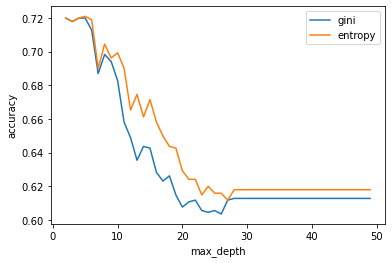

In [67]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(2,50):
    dtree = DecisionTreeClassifier(random_state=8,criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    ###
    dtree = DecisionTreeClassifier(random_state=8,criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

In [68]:
print(d.sort_values('acc_entropy',ascending=False)[0:5])

   acc_gini  acc_entropy  max_depth
3  0.719876     0.720906          5
0  0.719876     0.719876          2
2  0.719876     0.719876          4
4  0.712667     0.718847          6
1  0.717817     0.717817          3


In [69]:
clf2 = DecisionTreeClassifier(random_state=8,max_depth=5,criterion='entropy')
clf2 = clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)

In [70]:
cm2 = pd.DataFrame(confusion_matrix(y_pred2, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy:", round(accuracy_score(y_test, y_pred2),4))
print('Specificity:', round(specificity2,4))
print('Sensitivity', round(recall_score(y_test,y_pred2),4))
print('F1-Score:',  round(f1_score(y_test,y_pred2),4))
print('AUC:', round(roc_auc_score(y_test, y_pred2),4))
feature_imp(clf2)

,True Y=0,True Y=1
Predicted Y=0,13,14
Predicted Y=1,257,687


Accuracy: 0.7209
Specificity: 0.0481
Sensitivity 0.98
F1-Score: 0.8353
AUC: 0.5141


[('Lifestage_Yankys', 0.251),
 ('BMI_Under Weight', 0.149),
 ('Ethnicity_Central Others', 0.116),
 ('Income_Income < 1500', 0.07),
 ('Ethnicity_East Coast Malay', 0.048),
 ('#HH_5 Member HH', 0.046),
 ('Ethnicity_North Chinese', 0.041),
 ('Income_Income >5000', 0.034),
 ('Ethnicity_South Malay', 0.029),
 ('BMI_Over Weight', 0.026),
 ('Ethnicity_Central Malay', 0.024),
 ('Lifestage_Teens and Toddlers', 0.023),
 ('BMI_Healthy', 0.02),
 ('Lifestage_Empty Nesters', 0.02),
 ('Lifestage_Teens Aches', 0.02),
 ('Ethnicity_East Coast Others', 0.017),
 ('#HH_4 Member HH', 0.016),
 ('location_North', 0.016),
 ('BMI_Obese', 0.014),
 ('Income_Income 3000 - 3999', 0.014),
 ('location_South', 0.005)]

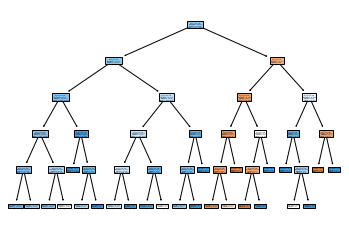

In [71]:
plt.figure()
tree.plot_tree(clf2,filled=True)  
plt.savefig('product_4_decisiontree.eps',format='eps',bbox_inches = "tight") #save trees using different groups

### Using RFM Clustering Groups for result analysis(Basket 1)

In [72]:
labelled_data = pd.read_csv("../data/RFM_group.csv")
labelled_data.head()

,Unnamed: 0,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,F_change,M_change,status
0,0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,0.0,0.0,Normal
1,1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,0.0,-1.0,Normal
2,2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,0.0,0.0,Loyal
3,3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,0.0,0.0,Loyal
4,4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,0.0,0.0,Normal


In [73]:
test_df = pd.DataFrame({'ID':X_test_id, 'true':y_test})
test_df = test_df.merge(labelled_data[['ID','status']], left_on ='ID', right_on='ID', how = 'left')
test_df.head()

,ID,true,status
0,Panel 225104101,1.0,Normal
1,Panel 800674401,0.0,Churned
2,Panel 800391601,0.0,Churned
3,Panel 801645301,0.0,Churning
4,Panel 109040101,1.0,Loyal


In [74]:
test_df['pred']=y_pred2
test_df.head()

,ID,true,status,pred
0,Panel 225104101,1.0,Normal,1.0
1,Panel 800674401,0.0,Churned,1.0
2,Panel 800391601,0.0,Churned,1.0
3,Panel 801645301,0.0,Churning,1.0
4,Panel 109040101,1.0,Loyal,1.0


In [75]:
for status in ["Improving","Loyal","Normal","Churning"]:
    cm2 = pd.DataFrame(confusion_matrix(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']))
    cm2.columns = ['True Y=0','True Y=1']
    cm2.index = ['Predicted Y=0','Predicted Y=1']
    display(cm2)
    print(f"Accuracy for {status}:",round(accuracy_score(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']),4))
    

,True Y=0,True Y=1
Predicted Y=0,2,2
Predicted Y=1,20,54


Accuracy for Improving: 0.7179


,True Y=0,True Y=1
Predicted Y=0,0,3
Predicted Y=1,7,178


Accuracy for Loyal: 0.9468


,True Y=0,True Y=1
Predicted Y=0,6,7
Predicted Y=1,127,366


Accuracy for Normal: 0.7352


,True Y=0,True Y=1
Predicted Y=0,2,1
Predicted Y=1,24,52


Accuracy for Churning: 0.6835


### Product Basket 2

In [76]:
data_for_model = data.groupby(['Panel ID','Category']).agg({'Spend': lambda x : x.sum()}).reset_index()

In [77]:
cat_data.reset_index(drop=True, inplace=True)
cat_data

,Category,Calories/100g,Price per Volume
0,Baby Cereal,188,29.41
1,Beer,43,15.12
2,Belacan,563,39.47
3,Bird Nest,46,73.45
4,Biscuits,416,15.57
...,...,...,...
57,Tea,1,38.68
58,Tonic Food Drink,548,15.21
59,Wine,83,88.13
60,Yoghurt Drink,90,6.47


In [78]:
data_for_model_full = cat_data.merge(data_for_model, how='outer')
data_for_model_full.head()

,Category,Calories/100g,Price per Volume,Panel ID,Spend
0,Baby Cereal,188,29.41,Panel 105044101,10.3
1,Baby Cereal,188,29.41,Panel 105052101,23.2
2,Baby Cereal,188,29.41,Panel 106077101,40.8
3,Baby Cereal,188,29.41,Panel 107009103,9.9
4,Baby Cereal,188,29.41,Panel 107030101,14.2


In [79]:
product_2 = seg_data2[seg_data2['Clusters']==2].Category
list(product_2)


['Butter', 'Cooking Oils', 'Margarine', 'Peanut Butter', 'Tonic Food Drink']

In [80]:
data_full_2 = data_for_model_full[data_for_model_full['Category'].isin(product_2)]
data_full_2 #all transactions that bought food items in food basket 2

,Category,Calories/100g,Price per Volume,Panel ID,Spend
6537,Butter,720,24.68,Panel 101011101,45.4
6538,Butter,720,24.68,Panel 105044101,30.7
6539,Butter,720,24.68,Panel 105052101,24.3
6540,Butter,720,24.68,Panel 105055101,14.5
6541,Butter,720,24.68,Panel 105058101,9.0
...,...,...,...,...,...
94367,Tonic Food Drink,548,15.21,Panel 801899801,157.2
94368,Tonic Food Drink,548,15.21,Panel 801900301,30.0
94369,Tonic Food Drink,548,15.21,Panel 801900701,37.9
94370,Tonic Food Drink,548,15.21,Panel 801901201,33.2


In [81]:
data_full_2 = data_full_2.groupby('Panel ID').agg({'Spend': lambda x : x.sum()}).reset_index()
data_full_2 ##sum up each customer's spending on foods in food basket 2

,Panel ID,Spend
0,Panel 101011101,541.1
1,Panel 101016101,362.0
2,Panel 101019101,827.6
3,Panel 101024101,660.8
4,Panel 105009103,1213.3
...,...,...
3139,Panel 801900301,55.4
3140,Panel 801900701,51.7
3141,Panel 801901201,90.4
3142,Panel 801903801,20.5


In [82]:
spend_group = data_full_2['Spend'].quantile([.25, .5,.75])
print(spend_group)

0.25    124.925
0.50    385.900
0.75    762.825
Name: Spend, dtype: float64


In [83]:
data_full_2 = data_full_2.merge(pd.DataFrame(panelist, columns = ['Panel ID']), how = "outer").fillna(0)
data_full_2   #full customer list including those did not buy foods in basket 2

,Panel ID,Spend
0,Panel 101011101,541.1
1,Panel 101016101,362.0
2,Panel 101019101,827.6
3,Panel 101024101,660.8
4,Panel 105009103,1213.3
...,...,...
3231,Panel 801812401,0.0
3232,Panel 801818001,0.0
3233,Panel 801820901,0.0
3234,Panel 801822701,0.0


In [84]:
data_full_2['Spend'].values[data_full_2['Spend'].values<=125]=0
data_full_2['Spend'].values[data_full_2['Spend'].values> 125]=1
data_full_2

,Panel ID,Spend
0,Panel 101011101,1.0
1,Panel 101016101,1.0
2,Panel 101019101,1.0
3,Panel 101024101,1.0
4,Panel 105009103,1.0
...,...,...
3231,Panel 801812401,0.0
3232,Panel 801818001,0.0
3233,Panel 801820901,0.0
3234,Panel 801822701,0.0


In [85]:
len(data_full_2[data_full_2['Spend']==0].Spend)  ##879 are classifed as not buying.

879

In [86]:
overall2 = data_full_2.merge(panel_data,left_on='Panel ID', right_on='ID')
overall2.drop(['ID'],axis=1,inplace=True)
overall2

,Panel ID,Spend,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,1.0,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,1.0,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,1.0,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,1.0,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,1.0,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North
...,...,...,...,...,...,...,...,...,...
3231,Panel 801812401,0.0,Healthy,Income >5000,South Malay,Nesting Families,Urban,4 Member HH,South
3232,Panel 801818001,0.0,Over Weight,Income < 1500,East Coast Malay,Yankys,Urban,1-3 Member HH,East Coast
3233,Panel 801820901,0.0,Healthy,Income 3000 - 3999,North Malay,Nesting Families,Rural,7+ Member HH,North
3234,Panel 801822701,0.0,Over Weight,Income 2000 - 2999,Central Malay,Teens and Toddlers,Urban,7+ Member HH,Central


In [87]:
overall2["Ethnicity"] = overall2["Ethnicity"].str.split().str[-1]

In [88]:
overall2

,Panel ID,Spend,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,1.0,Obese,Income 1500 - 1999,Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,1.0,Healthy,Income 1500 - 1999,Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,1.0,Obese,Income < 1500,Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,1.0,Over Weight,Income 1500 - 1999,Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,1.0,Over Weight,Income < 1500,Malay,Empty Nesters,Rural,1-3 Member HH,North
...,...,...,...,...,...,...,...,...,...
3231,Panel 801812401,0.0,Healthy,Income >5000,Malay,Nesting Families,Urban,4 Member HH,South
3232,Panel 801818001,0.0,Over Weight,Income < 1500,Malay,Yankys,Urban,1-3 Member HH,East Coast
3233,Panel 801820901,0.0,Healthy,Income 3000 - 3999,Malay,Nesting Families,Rural,7+ Member HH,North
3234,Panel 801822701,0.0,Over Weight,Income 2000 - 2999,Malay,Teens and Toddlers,Urban,7+ Member HH,Central


In [89]:
X = overall2.drop('Spend',1)
y = overall2.Spend

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8,random_state=8)

In [91]:
X_test_id = X_test['Panel ID']

In [92]:
#Remove the id column
X_train = X_train.drop(columns=['Panel ID'])
X_test = X_test.drop(columns=['Panel ID'])

In [93]:
X_test.columns

Index(['BMI', 'Income', 'Ethnicity', 'Lifestage', 'Strata', '#HH', 'location'], dtype='object')

In [94]:
X_train = pd.get_dummies(X_train, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])
X_test = pd.get_dummies(X_test, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])

In [95]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [96]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=8)

# The features are always randomly permuted at each split.
#  To obtain a deterministic behaviour during fitting, random_state has to be fixed.

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [97]:
print(clf.get_n_leaves())
print(clf.get_depth())
print(clf.get_params())

868
23
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 8, 'splitter': 'best'}


In [98]:
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(10, 100, num = 90)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt']

In [99]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,72,137
Predicted Y=1,126,313


Accuracy: 0.5941
Specificity: 0.3636
Sensitivity 0.6956
F1-Score: 0.7042
AUC: 0.5296


[('Income_Income 3000 - 3999', 0.055),
 ('Income_Income >5000', 0.05),
 ('Lifestage_Nesting Families', 0.048),
 ('location_East Coast', 0.047),
 ('#HH_5 Member HH', 0.045),
 ('#HH_4 Member HH', 0.044),
 ('location_North', 0.044),
 ('Income_Income 2000 - 2999', 0.043),
 ('location_South', 0.041),
 ('Strata_Urban', 0.039),
 ('#HH_6 Member HH', 0.039),
 ('Income_Income 1500 - 1999', 0.038),
 ('Income_Income 4000 - 4999', 0.038),
 ('Income_Income < 1500', 0.038),
 ('Lifestage_Teens Aches', 0.038),
 ('BMI_Healthy', 0.035),
 ('Lifestage_Yankys', 0.034),
 ('BMI_Obese', 0.032),
 ('BMI_Under Weight', 0.031),
 ('#HH_1-3 Member HH', 0.031),
 ('Strata_Rural', 0.029),
 ('location_Central', 0.029),
 ('Ethnicity_Malay', 0.025),
 ('#HH_7+ Member HH', 0.025),
 ('BMI_Over Weight', 0.019),
 ('Lifestage_Teens and Toddlers', 0.017),
 ('Lifestage_Matured Families', 0.015),
 ('Lifestage_Empty Nesters', 0.012),
 ('Ethnicity_Chinese', 0.011),
 ('Ethnicity_Others', 0.007)]

Best max_depth for gini: 2
Best max_depth for entropy: 2


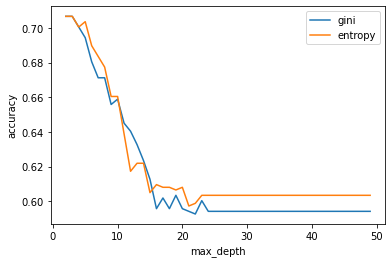

In [100]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(2,50):
    dtree = DecisionTreeClassifier(random_state=8,criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    ###
    dtree = DecisionTreeClassifier(random_state=8,criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

In [101]:
print(d.sort_values('acc_gini',ascending=False))

    acc_gini  acc_entropy  max_depth
0   0.706790     0.706790          2
1   0.706790     0.706790          3
2   0.700617     0.700617          4
3   0.694444     0.703704          5
4   0.680556     0.689815          6
5   0.671296     0.683642          7
6   0.671296     0.677469          8
8   0.658951     0.660494         10
7   0.655864     0.660494          9
9   0.645062     0.638889         11
10  0.640432     0.617284         12
11  0.632716     0.621914         13
12  0.623457     0.621914         14
13  0.612654     0.604938         15
17  0.603395     0.606481         19
15  0.601852     0.608025         17
21  0.600309     0.603395         23
18  0.595679     0.608025         20
16  0.595679     0.608025         18
14  0.595679     0.609568         16
46  0.594136     0.603395         48
45  0.594136     0.603395         47
34  0.594136     0.603395         36
44  0.594136     0.603395         46
43  0.594136     0.603395         45
42  0.594136     0.603395         44
4

In [102]:
clf2 = DecisionTreeClassifier(random_state=8,max_depth=2,criterion='gini')
clf2 = clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)

In [103]:
cm2 = pd.DataFrame(confusion_matrix(y_pred2, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy:", round(accuracy_score(y_test, y_pred2),4))
print('Specificity:', round(specificity2,4))
print('Sensitivity', round(recall_score(y_test,y_pred2),4))
print('F1-Score:',  round(f1_score(y_test,y_pred2),4))
print('AUC:', round(roc_auc_score(y_test, y_pred2),4))
feature_imp(clf2)

,True Y=0,True Y=1
Predicted Y=0,32,24
Predicted Y=1,166,426


Accuracy: 0.7068
Specificity: 0.1616
Sensitivity 0.9467
F1-Score: 0.8177
AUC: 0.5541


[('Lifestage_Nesting Families', 0.506),
 ('Lifestage_Yankys', 0.36),
 ('BMI_Under Weight', 0.134)]

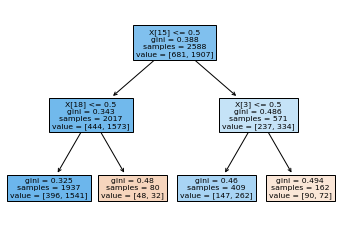

In [104]:
plt.figure()
tree.plot_tree(clf2,filled=True)  
plt.savefig('decisiontree.eps',format='eps',bbox_inches = "tight")

### Using RFM Clustering Groups for result analysis(Basket 2)

In [105]:
labelled_data = pd.read_csv("../data/RFM_group.csv")
labelled_data.head()

,Unnamed: 0,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,F_change,M_change,status
0,0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,0.0,0.0,Normal
1,1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,0.0,-1.0,Normal
2,2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,0.0,0.0,Loyal
3,3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,0.0,0.0,Loyal
4,4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,0.0,0.0,Normal


In [106]:
test_df = pd.DataFrame({'ID':X_test_id, 'true':y_test})
test_df = test_df.merge(labelled_data[['ID','status']], left_on ='ID', right_on='ID', how = 'left')
test_df.head()

,ID,true,status
0,Panel 224117101,1.0,Loyal
1,Panel 800604201,1.0,Normal
2,Panel 800308701,1.0,Normal
3,Panel 801621301,0.0,Churning
4,Panel 109030101,1.0,Loyal


In [107]:
test_df['pred']=y_pred2
test_df.head()

,ID,true,status,pred
0,Panel 224117101,1.0,Loyal,1.0
1,Panel 800604201,1.0,Normal,0.0
2,Panel 800308701,1.0,Normal,0.0
3,Panel 801621301,0.0,Churning,1.0
4,Panel 109030101,1.0,Loyal,1.0


In [108]:
for status in ["Improving","Loyal","Normal","Churning"]:
    cm2 = pd.DataFrame(confusion_matrix(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']))
    cm2.columns = ['True Y=0','True Y=1']
    cm2.index = ['Predicted Y=0','Predicted Y=1']
    display(cm2)
    print(f"Accuracy for {status}:",round(accuracy_score(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']),4))
 

,True Y=0,True Y=1
Predicted Y=0,1,1
Predicted Y=1,8,26


Accuracy for Improving: 0.75


,True Y=0,True Y=1
Predicted Y=0,0,2
Predicted Y=1,1,93


Accuracy for Loyal: 0.9688


,True Y=0,True Y=1
Predicted Y=0,9,15
Predicted Y=1,79,258


Accuracy for Normal: 0.7396


,True Y=0,True Y=1
Predicted Y=0,1,3
Predicted Y=1,12,38


Accuracy for Churning: 0.7222


### Product Basket 3

In [109]:
# Based on which product group(7 groups in total)
product_3 = seg_data2[seg_data2['Clusters']==3].Category
list(product_3)

['Bird Nest', 'Chicken Essence', 'Wine']

In [110]:
data_for_model = data.groupby(['Panel ID','Category']).agg({'Spend': lambda x : x.sum()}).reset_index()

In [111]:
cat_data.reset_index(drop=True, inplace=True)
cat_data.head()

,Category,Calories/100g,Price per Volume
0,Baby Cereal,188,29.41
1,Beer,43,15.12
2,Belacan,563,39.47
3,Bird Nest,46,73.45
4,Biscuits,416,15.57


In [112]:
data_for_model_full = cat_data.merge(data_for_model, how='outer')

In [113]:
data_for_model_full.head()

,Category,Calories/100g,Price per Volume,Panel ID,Spend
0,Baby Cereal,188,29.41,Panel 105044101,10.3
1,Baby Cereal,188,29.41,Panel 105052101,23.2
2,Baby Cereal,188,29.41,Panel 106077101,40.8
3,Baby Cereal,188,29.41,Panel 107009103,9.9
4,Baby Cereal,188,29.41,Panel 107030101,14.2


In [114]:
# change name of data_full_4 to match each product group
data_full_3 = data_for_model_full[data_for_model_full['Category'].isin(product_3)]
data_full_3

,Category,Calories/100g,Price per Volume,Panel ID,Spend
1472,Bird Nest,46,73.45,Panel 105048101,10.0
1473,Bird Nest,46,73.45,Panel 109013101,220.8
1474,Bird Nest,46,73.45,Panel 109024101,379.1
1475,Bird Nest,46,73.45,Panel 110057101,12.0
1476,Bird Nest,46,73.45,Panel 110058101,120.0
...,...,...,...,...,...
94460,Wine,83,88.13,Panel 801228901,150.0
94461,Wine,83,88.13,Panel 801585701,150.0
94462,Wine,83,88.13,Panel 801626601,309.7
94463,Wine,83,88.13,Panel 801697801,22.0


In [115]:
data

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6
...,...,...,...,...,...,...
1318019,Panel 801912801,2020-02-23,MSG,1,0.1,2.2
1318020,Panel 801912801,2020-02-23,Eggs,1,30.0,8.4
1318021,Panel 801912801,2020-02-23,Ice Cream,1,1.5,8.0
1318022,Panel 801912801,2020-02-23,Cooking Sauces,1,0.7,4.8


In [116]:
data_full_3 = data_full_3.groupby('Panel ID').agg({'Spend': lambda x : x.sum()}).reset_index()
data_full_3.head()

,Panel ID,Spend
0,Panel 105048101,10.0
1,Panel 106061101,584.4
2,Panel 106082101,30.0
3,Panel 109013101,291.7
4,Panel 109024101,379.1


In [117]:
data_full_3 = data_full_3.merge(pd.DataFrame(panelist, columns = ['Panel ID']), how = "outer").fillna(0)
print(data_full_3[data_full_3.Spend == 0].shape)
print(data_full_3[data_full_3.Spend != 0].shape)
#data_full_3 = data_full_3[data_full_3.Spend != 0]

(2858, 2)
(378, 2)


In [118]:
data_full_3

,Panel ID,Spend
0,Panel 105048101,10.0
1,Panel 106061101,584.4
2,Panel 106082101,30.0
3,Panel 109013101,291.7
4,Panel 109024101,379.1
...,...,...
3231,Panel 801900701,0.0
3232,Panel 801901201,0.0
3233,Panel 801903201,0.0
3234,Panel 801903801,0.0


In [119]:
spend_group = data_full_3['Spend'].quantile([0.9])   
print(spend_group)

0.9    29.9
Name: Spend, dtype: float64


In [120]:
# if the spending satisfies some certain criteria (like <0.3 quantile, based on different basket),
# than assign to be not buying(1);
# otherwise, assign to buying(0)
data_full_3['Spend'].values[data_full_3['Spend'].values<=spend_group[0.9]]=0
data_full_3['Spend'].values[data_full_3['Spend'].values>spend_group[0.9]]=1
data_full_3

,Panel ID,Spend
0,Panel 105048101,0.0
1,Panel 106061101,1.0
2,Panel 106082101,1.0
3,Panel 109013101,1.0
4,Panel 109024101,1.0
...,...,...
3231,Panel 801900701,0.0
3232,Panel 801901201,0.0
3233,Panel 801903201,0.0
3234,Panel 801903801,0.0


In [121]:
len(data_full_3[data_full_3['Spend']==0].Spend)

2913

In [122]:
overall3 = data_full_3.merge(panel_data,left_on='Panel ID', right_on='ID')
overall3.drop(['ID'],axis=1,inplace=True)
overall3

,Panel ID,Spend,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 105048101,0.0,Obese,Income 1500 - 1999,North Malay,Teens Aches,Rural,4 Member HH,North
1,Panel 106061101,1.0,Healthy,Income 4000 - 4999,North Chinese,Empty Nesters,Urban,1-3 Member HH,North
2,Panel 106082101,1.0,Under Weight,Income 3000 - 3999,North Chinese,Empty Nesters,Urban,4 Member HH,North
3,Panel 109013101,1.0,Healthy,Income >5000,North Chinese,Teens Aches,Urban,1-3 Member HH,North
4,Panel 109024101,1.0,Healthy,Income 2000 - 2999,North Malay,Teens Aches,Urban,1-3 Member HH,North
...,...,...,...,...,...,...,...,...,...
3231,Panel 801900701,0.0,Healthy,Income >5000,Central Others,Yankys,Urban,1-3 Member HH,Central
3232,Panel 801901201,0.0,Over Weight,Income >5000,Central Malay,Teens and Toddlers,Urban,6 Member HH,Central
3233,Panel 801903201,0.0,Obese,Income 3000 - 3999,Central Malay,Teens and Toddlers,Urban,7+ Member HH,Central
3234,Panel 801903801,0.0,Healthy,Income 1500 - 1999,Central Malay,Yankys,Urban,1-3 Member HH,Central


In [123]:
X = overall3.drop('Spend',1)
y = overall3.Spend
X = pd.get_dummies(X, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=8)

In [125]:
X_test_id = X_test['Panel ID']

In [126]:
#Remove the id column
X_train = X_train.drop(columns=['Panel ID'])
X_test = X_test.drop(columns=['Panel ID'])

In [127]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [128]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=8)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [129]:
print(clf.get_n_leaves())
print(clf.get_depth())
print(clf.get_params())

355
18
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 8, 'splitter': 'best'}


In [130]:
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(10, 100, num = 90)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt']

In [131]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,812,72
Predicted Y=1,62,25


Accuracy: 0.862
Specificity: 0.9291
Sensitivity 0.2577
F1-Score: 0.2717
AUC: 0.5934


[('Ethnicity_Central Chinese', 0.091),
 ('Lifestage_Teens Aches', 0.069),
 ('Income_Income >5000', 0.055),
 ('BMI_Over Weight', 0.053),
 ('BMI_Healthy', 0.048),
 ('#HH_4 Member HH', 0.043),
 ('Income_Income 2000 - 2999', 0.041),
 ('Ethnicity_North Chinese', 0.041),
 ('Lifestage_Matured Families', 0.041),
 ('Income_Income 4000 - 4999', 0.039),
 ('Ethnicity_South Chinese', 0.036),
 ('Lifestage_Teens and Toddlers', 0.035),
 ('#HH_1-3 Member HH', 0.035),
 ('#HH_5 Member HH', 0.035),
 ('#HH_6 Member HH', 0.035),
 ('Lifestage_Empty Nesters', 0.033),
 ('Income_Income 3000 - 3999', 0.031),
 ('Lifestage_Nesting Families', 0.03),
 ('BMI_Obese', 0.028),
 ('BMI_Under Weight', 0.028),
 ('Strata_Rural', 0.025),
 ('Income_Income 1500 - 1999', 0.015),
 ('#HH_7+ Member HH', 0.015),
 ('Ethnicity_East Coast Chinese', 0.012),
 ('Income_Income < 1500', 0.011),
 ('Ethnicity_North Malay', 0.011),
 ('Strata_Urban', 0.011),
 ('location_North', 0.011),
 ('Ethnicity_Central Malay', 0.009),
 ('Ethnicity_Central O

Best max_depth for gini: 5
Best max_depth for entropy: 5


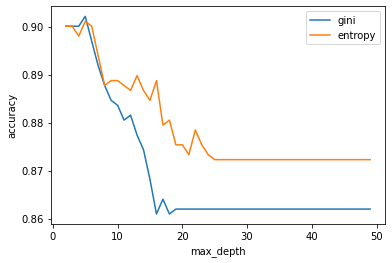

In [132]:
max_depth = []
acc_gini = []
acc_entropy = []
f1_gini = []
f1_entropy = []
for i in range(2,50):
    dtree = DecisionTreeClassifier(random_state=8,criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    f1_gini.append(f1_score(y_test, pred))
    ###
    dtree = DecisionTreeClassifier(random_state=8,criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    f1_entropy.append(f1_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini),'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
e = pd.DataFrame({'f1_gini':pd.Series(f1_gini),'f1_entropy':pd.Series(f1_entropy),
    'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

In [133]:
print(d.sort_values('acc_gini',ascending=False)[0:5])

   acc_gini  acc_entropy  max_depth
3  0.902163     0.901133          5
0  0.900103     0.900103          2
1  0.900103     0.900103          3
2  0.900103     0.898043          4
4  0.897013     0.900103          6


In [134]:
print(e.sort_values('f1_gini',ascending=False)[0:5])

     f1_gini  f1_entropy  max_depth
11  0.320000    0.318471         13
9   0.317647    0.296774         11
10  0.311377    0.266667         12
14  0.307692    0.333333         16
12  0.306818    0.294872         14


In [135]:
clf2 = DecisionTreeClassifier(random_state=8,max_depth=5,criterion='gini')
clf2 = clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)

In [136]:
cm2 = pd.DataFrame(confusion_matrix(y_pred2, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy:", round(accuracy_score(y_test, y_pred2),4))
print('Specificity:', round(specificity2,4))
print('Sensitivity', round(recall_score(y_test,y_pred2),4))
print('F1-Score:',  round(f1_score(y_test,y_pred2),4))
print('AUC:', round(roc_auc_score(y_test, y_pred2),4))
feature_imp(clf2)

,True Y=0,True Y=1
Predicted Y=0,868,89
Predicted Y=1,6,8


Accuracy: 0.9022
Specificity: 0.9931
Sensitivity 0.0825
F1-Score: 0.1441
AUC: 0.5378


[('Ethnicity_Central Chinese', 0.303),
 ('Ethnicity_North Chinese', 0.135),
 ('Ethnicity_South Chinese', 0.12),
 ('Lifestage_Teens Aches', 0.076),
 ('Lifestage_Matured Families', 0.056),
 ('Ethnicity_East Coast Chinese', 0.04),
 ('#HH_4 Member HH', 0.031),
 ('Income_Income >5000', 0.029),
 ('#HH_6 Member HH', 0.029),
 ('BMI_Over Weight', 0.025),
 ('Income_Income 3000 - 3999', 0.023),
 ('Ethnicity_Central Others', 0.023),
 ('#HH_5 Member HH', 0.023),
 ('BMI_Obese', 0.022),
 ('BMI_Under Weight', 0.016),
 ('Lifestage_Nesting Families', 0.013),
 ('Income_Income 4000 - 4999', 0.011),
 ('Income_Income < 1500', 0.011),
 ('Strata_Rural', 0.009),
 ('BMI_Healthy', 0.004)]

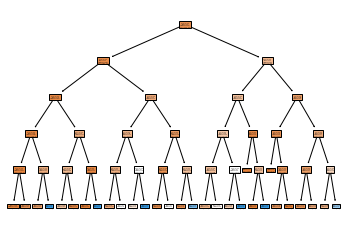

In [137]:
plt.figure()
tree.plot_tree(clf2,filled=True)  
plt.savefig('product_3_decisiontree.eps',format='eps',bbox_inches = "tight") #save trees using different groups

### Using RFM Clustering Groups for result analysis (Basket 3)

In [138]:
labelled_data = pd.read_csv("../data/RFM_group.csv")
labelled_data.head()

,Unnamed: 0,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,F_change,M_change,status
0,0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,0.0,0.0,Normal
1,1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,0.0,-1.0,Normal
2,2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,0.0,0.0,Loyal
3,3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,0.0,0.0,Loyal
4,4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,0.0,0.0,Normal


In [139]:
labelled_data.status.unique()

array(['Normal', 'Loyal', 'Improving', 'Churned', 'Churning'],
      dtype=object)

In [140]:
test_df = pd.DataFrame({'ID':X_test_id, 'true':y_test})
test_df = test_df.merge(labelled_data[['ID','status']], left_on ='ID', right_on='ID', how = 'left')
test_df.head()

,ID,true,status
0,Panel 201007101,0.0,Churning
1,Panel 800491701,0.0,Churned
2,Panel 800201101,0.0,Normal
3,Panel 801549101,0.0,Normal
4,Panel 187021101,1.0,Normal


In [141]:
test_df['pred']=y_pred2
test_df.head()

,ID,true,status,pred
0,Panel 201007101,0.0,Churning,0.0
1,Panel 800491701,0.0,Churned,0.0
2,Panel 800201101,0.0,Normal,0.0
3,Panel 801549101,0.0,Normal,0.0
4,Panel 187021101,1.0,Normal,0.0


In [142]:
test_df[test_df.status == "Improving"]

,ID,true,status,pred
14,Panel 801858201,0.0,Improving,0.0
20,Panel 801398301,0.0,Improving,0.0
24,Panel 801810301,0.0,Improving,0.0
37,Panel 801830001,0.0,Improving,0.0
49,Panel 132021101,0.0,Improving,0.0
...,...,...,...,...
860,Panel 185026101,0.0,Improving,0.0
903,Panel 239009101,0.0,Improving,0.0
905,Panel 801485001,1.0,Improving,0.0
933,Panel 801707701,0.0,Improving,0.0


In [143]:
for status in ["Improving","Loyal","Normal","Churning"]:
    cm2 = pd.DataFrame(confusion_matrix(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']))
    cm2.columns = ['True Y=0','True Y=1']
    cm2.index = ['Predicted Y=0','Predicted Y=1']
    display(cm2)
    print(f"Accuracy for {status}:",round(accuracy_score(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']),4))
    

,True Y=0,True Y=1
Predicted Y=0,63,6
Predicted Y=1,0,0


Accuracy for Improving: 0.913


,True Y=0,True Y=1
Predicted Y=0,140,29
Predicted Y=1,2,6


Accuracy for Loyal: 0.8249


,True Y=0,True Y=1
Predicted Y=0,446,52
Predicted Y=1,4,0


Accuracy for Normal: 0.8884


,True Y=0,True Y=1
Predicted Y=0,76,1
Predicted Y=1,0,2


Accuracy for Churning: 0.9873


### Product Basket 4

In [144]:
# Based on which product group(7 groups in total)
product_4 = seg_data2[seg_data2['Clusters']==5].Category
list(product_4)

['Beer',
 'CSD',
 'Cultured Milk',
 'Drinking Water',
 'Eggs',
 'Energy Drinks',
 'Fruit/Veg Juices',
 'Isotonic Drinks',
 'Liquid Milk',
 'RTD Coffee',
 'RTD Tea',
 'Soy Milk',
 'Yoghurt Drink',
 'Yoghurts']

In [145]:
data_for_model = data.groupby(['Panel ID','Category']).agg({'Spend': lambda x : x.sum()}).reset_index()

In [146]:
cat_data.reset_index(drop=True, inplace=True)
cat_data.head()

,Category,Calories/100g,Price per Volume
0,Baby Cereal,188,29.41
1,Beer,43,15.12
2,Belacan,563,39.47
3,Bird Nest,46,73.45
4,Biscuits,416,15.57


In [147]:
data_for_model_full = cat_data.merge(data_for_model, how='outer')

In [148]:
data_for_model_full.head()

,Category,Calories/100g,Price per Volume,Panel ID,Spend
0,Baby Cereal,188,29.41,Panel 105044101,10.3
1,Baby Cereal,188,29.41,Panel 105052101,23.2
2,Baby Cereal,188,29.41,Panel 106077101,40.8
3,Baby Cereal,188,29.41,Panel 107009103,9.9
4,Baby Cereal,188,29.41,Panel 107030101,14.2


In [149]:
# change name of data_full_4 to match each product group
data_full_4 = data_for_model_full[data_for_model_full['Category'].isin(product_4)]
data_full_4

,Category,Calories/100g,Price per Volume,Panel ID,Spend
277,Beer,43,15.12,Panel 106014103,314.6
278,Beer,43,15.12,Panel 106016101,98.7
279,Beer,43,15.12,Panel 106023104,77.7
280,Beer,43,15.12,Panel 106024101,839.6
281,Beer,43,15.12,Panel 106059101,640.7
...,...,...,...,...,...
97133,Yoghurts,61,14.24,Panel 801853901,21.7
97134,Yoghurts,61,14.24,Panel 801891101,7.2
97135,Yoghurts,61,14.24,Panel 801900301,4.0
97136,Yoghurts,61,14.24,Panel 801900701,1.4


In [150]:
data_full_4 = data_full_4.groupby('Panel ID').agg({'Spend': lambda x : x.sum()}).reset_index()
data_full_4.head()

,Panel ID,Spend
0,Panel 101011101,396.0
1,Panel 101016101,83.7
2,Panel 101019101,944.1
3,Panel 101024101,1127.2
4,Panel 105009103,546.6


In [151]:
data_full_4 = data_full_4.merge(pd.DataFrame(panelist, columns = ['Panel ID']), how = "outer").fillna(0)
data_full_4.head()

,Panel ID,Spend
0,Panel 101011101,396.0
1,Panel 101016101,83.7
2,Panel 101019101,944.1
3,Panel 101024101,1127.2
4,Panel 105009103,546.6


In [152]:
spend_group = data_full_4['Spend'].quantile([ .25,.3, .5,.75])   
print(spend_group)

0.25    100.300
0.30    145.450
0.50    365.250
0.75    794.725
Name: Spend, dtype: float64


In [153]:
len(data_full_4[data_full_4['Spend']!=0])

3143

In [154]:
# if the spending satisfies some certain criteria (like <0.3 quantile, based on different basket),
# than assign to be not buying(1);
# otherwise, assign to buying(0)
data_full_4['Spend'].values[data_full_4['Spend'].values<=spend_group[0.3]]=0
data_full_4['Spend'].values[data_full_4['Spend'].values>spend_group[0.3]]=1
data_full_4

,Panel ID,Spend
0,Panel 101011101,1.0
1,Panel 101016101,0.0
2,Panel 101019101,1.0
3,Panel 101024101,1.0
4,Panel 105009103,1.0
...,...,...
3231,Panel 801759301,0.0
3232,Panel 801770901,0.0
3233,Panel 801815201,0.0
3234,Panel 801818001,0.0


In [155]:
len(data_full_4[data_full_4['Spend']==0].Spend)

971

In [156]:
overall4 = data_full_4.merge(panel_data,left_on='Panel ID', right_on='ID')
overall4.drop(['ID'],axis=1,inplace=True)
overall4 = overall4[['Panel ID','BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location","Spend"]]
overall4

,Panel ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,Spend
0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,1.0
1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,0.0
2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,1.0
3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,1.0
4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,1.0
...,...,...,...,...,...,...,...,...,...
3231,Panel 801759301,Healthy,Income >5000,South Malay,Matured Families,Urban,1-3 Member HH,South,0.0
3232,Panel 801770901,Healthy,Income 1500 - 1999,South Malay,Nesting Families,Urban,5 Member HH,South,0.0
3233,Panel 801815201,Healthy,Income 2000 - 2999,East Coast Malay,Teens and Toddlers,Urban,7+ Member HH,East Coast,0.0
3234,Panel 801818001,Over Weight,Income < 1500,East Coast Malay,Yankys,Urban,1-3 Member HH,East Coast,0.0


In [157]:
X = overall4.drop('Spend',1)
y = overall4.Spend

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=8)

In [159]:
X_test_id = X_test['Panel ID']

In [160]:
#Remove the id column
X_train = X_train.drop(columns=['Panel ID'])
X_test = X_test.drop(columns=['Panel ID'])

In [161]:
X_test.columns

Index(['BMI', 'Income', 'Ethnicity', 'Lifestage', 'Strata', '#HH', 'location'], dtype='object')

In [162]:
X_train = pd.get_dummies(X_train, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])
X_test = pd.get_dummies(X_test, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])

In [163]:
X_test.columns

Index(['BMI_Healthy', 'BMI_Obese', 'BMI_Over Weight', 'BMI_Under Weight',
       'Income_Income 1500 - 1999', 'Income_Income 2000 - 2999',
       'Income_Income 3000 - 3999', 'Income_Income 4000 - 4999',
       'Income_Income < 1500', 'Income_Income >5000',
       'Ethnicity_Central Chinese', 'Ethnicity_Central Malay',
       'Ethnicity_Central Others', 'Ethnicity_East Coast Chinese',
       'Ethnicity_East Coast Malay', 'Ethnicity_East Coast Others',
       'Ethnicity_North Chinese', 'Ethnicity_North Malay',
       'Ethnicity_North Others', 'Ethnicity_South Chinese',
       'Ethnicity_South Malay', 'Ethnicity_South Others',
       'Lifestage_Empty Nesters', 'Lifestage_Matured Families',
       'Lifestage_Nesting Families', 'Lifestage_Teens Aches',
       'Lifestage_Teens and Toddlers', 'Lifestage_Yankys', 'Strata_Rural',
       'Strata_Urban', '#HH_1-3 Member HH', '#HH_4 Member HH',
       '#HH_5 Member HH', '#HH_6 Member HH', '#HH_7+ Member HH',
       'location_Central', 'location_E

In [164]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [165]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=8)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [166]:
print(clf.get_n_leaves())
print(clf.get_depth())
print(clf.get_params())

844
26
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 8, 'splitter': 'best'}


In [167]:
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(10, 100, num = 90)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt']

In [168]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,151,201
Predicted Y=1,167,452


Accuracy: 0.621
Specificity: 0.4748
Sensitivity 0.6922
F1-Score: 0.7107
AUC: 0.5835


[('Strata_Urban', 0.051),
 ('#HH_4 Member HH', 0.047),
 ('BMI_Over Weight', 0.046),
 ('BMI_Healthy', 0.045),
 ('Income_Income >5000', 0.045),
 ('#HH_6 Member HH', 0.044),
 ('#HH_1-3 Member HH', 0.043),
 ('Strata_Rural', 0.039),
 ('#HH_5 Member HH', 0.037),
 ('BMI_Under Weight', 0.036),
 ('Income_Income 3000 - 3999', 0.035),
 ('Lifestage_Nesting Families', 0.035),
 ('Income_Income 2000 - 2999', 0.031),
 ('Income_Income 1500 - 1999', 0.028),
 ('Income_Income < 1500', 0.027),
 ('Ethnicity_South Malay', 0.027),
 ('BMI_Obese', 0.026),
 ('Income_Income 4000 - 4999', 0.025),
 ('Ethnicity_East Coast Malay', 0.025),
 ('Ethnicity_North Malay', 0.025),
 ('Lifestage_Matured Families', 0.025),
 ('#HH_7+ Member HH', 0.025),
 ('Ethnicity_Central Chinese', 0.022),
 ('Ethnicity_Central Malay', 0.022),
 ('Lifestage_Teens and Toddlers', 0.021),
 ('location_North', 0.02),
 ('location_Central', 0.019),
 ('location_East Coast', 0.019),
 ('Ethnicity_Central Others', 0.017),
 ('Lifestage_Teens Aches', 0.017),

Best max_depth for gini: 2
Best max_depth for entropy: 2


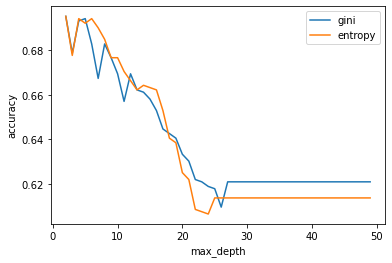

In [169]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(2,50):
    dtree = DecisionTreeClassifier(random_state=8,criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    ###
    dtree = DecisionTreeClassifier(random_state=8,criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')

plt.legend()
plt.savefig("pruning.png")
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

In [170]:
print(d.sort_values('acc_entropy',ascending=False)[0:5])

   acc_gini  acc_entropy  max_depth
0  0.695160      0.69516          2
2  0.693100      0.69413          4
4  0.682801      0.69413          6
3  0.694130      0.69207          5
5  0.667353      0.69001          7


In [171]:
clf2 = DecisionTreeClassifier(random_state=8,max_depth=3,criterion='entropy')
clf2 = clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)

In [172]:
cm2 = pd.DataFrame(confusion_matrix(y_pred2, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy:", round(accuracy_score(y_test, y_pred2),4))
print('Specificity:', round(specificity2,4))
print('Sensitivity', round(recall_score(y_test,y_pred2),4))
print('F1-Score:',  round(f1_score(y_test,y_pred2),4))
print('AUC:', round(roc_auc_score(y_test, y_pred2),4))
feature_imp(clf2)

,True Y=0,True Y=1
Predicted Y=0,8,3
Predicted Y=1,310,650


Accuracy: 0.6777
Specificity: 0.0252
Sensitivity 0.9954
F1-Score: 0.806
AUC: 0.5103


[('Lifestage_Nesting Families', 0.346),
 ('BMI_Under Weight', 0.254),
 ('Lifestage_Teens and Toddlers', 0.227),
 ('Ethnicity_Central Chinese', 0.074),
 ('Strata_Rural', 0.074),
 ('Ethnicity_East Coast Chinese', 0.026)]

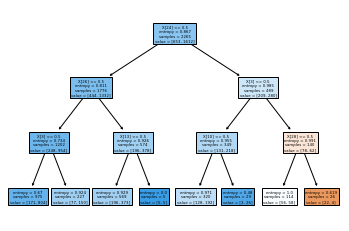

In [173]:
plt.figure()
tree.plot_tree(clf2,filled=True)  
plt.savefig('product_4_decisiontree.eps',format='eps',bbox_inches = "tight") #save trees using different groups

In [174]:
dotfile = open("tree.dot", 'w')
tree.export_graphviz(clf2,out_file = dotfile,
                     feature_names=X_test.columns,
                     class_names = [str(i) for i in clf2.classes_],
                     proportion=False) 
dotfile.close()

### Using RFM Clustering Groups for result analysis(Basket 4)

In [175]:
labelled_data = pd.read_csv("../data/RFM_group.csv")
labelled_data.head()

,Unnamed: 0,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,F_change,M_change,status
0,0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,0.0,0.0,Normal
1,1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,0.0,-1.0,Normal
2,2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,0.0,0.0,Loyal
3,3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,0.0,0.0,Loyal
4,4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,0.0,0.0,Normal


In [176]:
test_df = pd.DataFrame({'ID':X_test_id, 'true':y_test})
test_df = test_df.merge(labelled_data[['ID','status']], left_on ='ID', right_on='ID', how = 'left')
test_df.head()

,ID,true,status
0,Panel 225002101,1.0,Loyal
1,Panel 800603801,1.0,Normal
2,Panel 800305301,1.0,Loyal
3,Panel 801607501,0.0,Normal
4,Panel 109037101,1.0,Normal


In [177]:
test_df['pred']=y_pred2
test_df.head()

,ID,true,status,pred
0,Panel 225002101,1.0,Loyal,1.0
1,Panel 800603801,1.0,Normal,1.0
2,Panel 800305301,1.0,Loyal,1.0
3,Panel 801607501,0.0,Normal,1.0
4,Panel 109037101,1.0,Normal,1.0


In [178]:
for status in ["Improving","Loyal","Normal","Churning"]:
    cm2 = pd.DataFrame(confusion_matrix(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']))
    cm2.columns = ['True Y=0','True Y=1']
    cm2.index = ['Predicted Y=0','Predicted Y=1']
    display(cm2)
    print(f"Accuracy for {status}:",round(accuracy_score(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']),4))
    

,True Y=0,True Y=1
Predicted Y=0,0,0
Predicted Y=1,21,50


Accuracy for Improving: 0.7042


,True Y=0,True Y=1
Predicted Y=0,1,0
Predicted Y=1,3,162


Accuracy for Loyal: 0.9819


,True Y=0,True Y=1
Predicted Y=0,2,3
Predicted Y=1,139,350


Accuracy for Normal: 0.7126


,True Y=0,True Y=1
Predicted Y=0,1,0
Predicted Y=1,30,65


Accuracy for Churning: 0.6875


### Product Basket 5

In [179]:
product_5= list(seg_data2[seg_data2['Clusters']==5].Category)
product_5

['Beer',
 'CSD',
 'Cultured Milk',
 'Drinking Water',
 'Eggs',
 'Energy Drinks',
 'Fruit/Veg Juices',
 'Isotonic Drinks',
 'Liquid Milk',
 'RTD Coffee',
 'RTD Tea',
 'Soy Milk',
 'Yoghurt Drink',
 'Yoghurts']

In [180]:
data_for_model = data.groupby(['Panel ID','Category']).agg({'Spend': lambda x : x.sum()}).reset_index()

In [181]:
cat_data.reset_index(drop=True, inplace=True)
cat_data.head()

,Category,Calories/100g,Price per Volume
0,Baby Cereal,188,29.41
1,Beer,43,15.12
2,Belacan,563,39.47
3,Bird Nest,46,73.45
4,Biscuits,416,15.57


In [182]:
data_for_model_full = cat_data.merge(data_for_model, how='outer')

In [183]:
data_for_model_full.head()

,Category,Calories/100g,Price per Volume,Panel ID,Spend
0,Baby Cereal,188,29.41,Panel 105044101,10.3
1,Baby Cereal,188,29.41,Panel 105052101,23.2
2,Baby Cereal,188,29.41,Panel 106077101,40.8
3,Baby Cereal,188,29.41,Panel 107009103,9.9
4,Baby Cereal,188,29.41,Panel 107030101,14.2


In [184]:
data_full_5 = data_for_model_full[data_for_model_full['Category'].isin(product_5)]
data_full_5.head()

,Category,Calories/100g,Price per Volume,Panel ID,Spend
277,Beer,43,15.12,Panel 106014103,314.6
278,Beer,43,15.12,Panel 106016101,98.7
279,Beer,43,15.12,Panel 106023104,77.7
280,Beer,43,15.12,Panel 106024101,839.6
281,Beer,43,15.12,Panel 106059101,640.7


In [185]:
data_full_5 = data_full_5.groupby('Panel ID').agg({'Spend': lambda x : x.sum()}).reset_index()
data_full_5.head()

,Panel ID,Spend
0,Panel 101011101,396.0
1,Panel 101016101,83.7
2,Panel 101019101,944.1
3,Panel 101024101,1127.2
4,Panel 105009103,546.6


In [186]:
data_full_5 = data_full_5.merge(pd.DataFrame(panelist, columns = ['Panel ID']), how = "outer").fillna(0)
data_full_5.head()

,Panel ID,Spend
0,Panel 101011101,396.0
1,Panel 101016101,83.7
2,Panel 101019101,944.1
3,Panel 101024101,1127.2
4,Panel 105009103,546.6


In [187]:
spend_group = data_full_5['Spend'].quantile([ .25,.3, .5,.75])   
print(spend_group)

0.25    100.300
0.30    145.450
0.50    365.250
0.75    794.725
Name: Spend, dtype: float64


In [188]:
# if the spending satisfies some certain criteria (like <0.3 quantile, based on different basket),
# than assign to be not buying(1);
# otherwise, assign to buying(0)
data_full_5['Spend'].values[data_full_5['Spend'].values<=spend_group[0.3]]=0
data_full_5['Spend'].values[data_full_5['Spend'].values>spend_group[0.3]]=1
data_full_5

,Panel ID,Spend
0,Panel 101011101,1.0
1,Panel 101016101,0.0
2,Panel 101019101,1.0
3,Panel 101024101,1.0
4,Panel 105009103,1.0
...,...,...
3231,Panel 801759301,0.0
3232,Panel 801770901,0.0
3233,Panel 801815201,0.0
3234,Panel 801818001,0.0


In [189]:
len(data_full_5[data_full_5['Spend']==0].Spend)

971

In [190]:
overall5 = data_full_5.merge(panel_data,left_on='Panel ID', right_on='ID')
overall5.drop(['ID'],axis=1,inplace=True)
overall5

,Panel ID,Spend,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,1.0,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,0.0,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,1.0,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,1.0,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,1.0,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North
...,...,...,...,...,...,...,...,...,...
3231,Panel 801759301,0.0,Healthy,Income >5000,South Malay,Matured Families,Urban,1-3 Member HH,South
3232,Panel 801770901,0.0,Healthy,Income 1500 - 1999,South Malay,Nesting Families,Urban,5 Member HH,South
3233,Panel 801815201,0.0,Healthy,Income 2000 - 2999,East Coast Malay,Teens and Toddlers,Urban,7+ Member HH,East Coast
3234,Panel 801818001,0.0,Over Weight,Income < 1500,East Coast Malay,Yankys,Urban,1-3 Member HH,East Coast


In [191]:
X = overall5.drop('Spend',1)
y = overall5.Spend

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=8)

In [193]:
X_test_id = X_test['Panel ID']

In [194]:
#Remove the id column
X_train = X_train.drop(columns=['Panel ID'])
X_test = X_test.drop(columns=['Panel ID'])

In [195]:
X_test.columns

Index(['BMI', 'Income', 'Ethnicity', 'Lifestage', 'Strata', '#HH', 'location'], dtype='object')

In [196]:
X_train = pd.get_dummies(X_train, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])
X_test = pd.get_dummies(X_test, columns=['BMI','Income','Ethnicity', "Lifestage", "Strata", "#HH","location"])

In [197]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [198]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=8)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [199]:
print(clf.get_n_leaves())
print(clf.get_depth())
print(clf.get_params())

844
26
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 8, 'splitter': 'best'}


In [200]:
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(10, 100, num = 90)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt']

In [201]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,151,201
Predicted Y=1,167,452


Accuracy: 0.621
Specificity: 0.4748
Sensitivity 0.6922
F1-Score: 0.7107
AUC: 0.5835


[('Strata_Urban', 0.051),
 ('#HH_4 Member HH', 0.047),
 ('BMI_Over Weight', 0.046),
 ('BMI_Healthy', 0.045),
 ('Income_Income >5000', 0.045),
 ('#HH_6 Member HH', 0.044),
 ('#HH_1-3 Member HH', 0.043),
 ('Strata_Rural', 0.039),
 ('#HH_5 Member HH', 0.037),
 ('BMI_Under Weight', 0.036),
 ('Income_Income 3000 - 3999', 0.035),
 ('Lifestage_Nesting Families', 0.035),
 ('Income_Income 2000 - 2999', 0.031),
 ('Income_Income 1500 - 1999', 0.028),
 ('Income_Income < 1500', 0.027),
 ('Ethnicity_South Malay', 0.027),
 ('BMI_Obese', 0.026),
 ('Income_Income 4000 - 4999', 0.025),
 ('Ethnicity_East Coast Malay', 0.025),
 ('Ethnicity_North Malay', 0.025),
 ('Lifestage_Matured Families', 0.025),
 ('#HH_7+ Member HH', 0.025),
 ('Ethnicity_Central Chinese', 0.022),
 ('Ethnicity_Central Malay', 0.022),
 ('Lifestage_Teens and Toddlers', 0.021),
 ('location_North', 0.02),
 ('location_Central', 0.019),
 ('location_East Coast', 0.019),
 ('Ethnicity_Central Others', 0.017),
 ('Lifestage_Teens Aches', 0.017),

Best max_depth for gini: 2
Best max_depth for entropy: 2


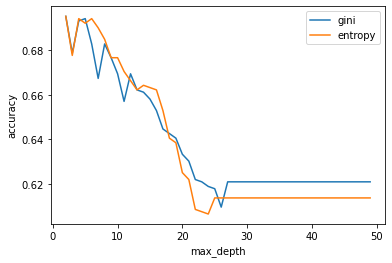

In [202]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(2,50):
    dtree = DecisionTreeClassifier(random_state=8,criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    ###
    dtree = DecisionTreeClassifier(random_state=8, criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

In [203]:
print(d.sort_values('acc_entropy',ascending=False)[0:5])

   acc_gini  acc_entropy  max_depth
0  0.695160      0.69516          2
2  0.693100      0.69413          4
4  0.682801      0.69413          6
3  0.694130      0.69207          5
5  0.667353      0.69001          7


In [204]:
clf2 = DecisionTreeClassifier(random_state=8,max_depth=2,criterion='entropy')
clf2 = clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)

In [205]:
cm2 = pd.DataFrame(confusion_matrix(y_pred2, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy:", round(accuracy_score(y_test, y_pred2),4))
print('Specificity:', round(specificity2,4))
print('Sensitivity', round(recall_score(y_test,y_pred2),4))
print('F1-Score:',  round(f1_score(y_test,y_pred2),4))
print('AUC:', round(roc_auc_score(y_test, y_pred2),4))
feature_imp(clf2)

,True Y=0,True Y=1
Predicted Y=0,44,22
Predicted Y=1,274,631


Accuracy: 0.6952
Specificity: 0.1384
Sensitivity 0.9663
F1-Score: 0.81
AUC: 0.5523


[('Lifestage_Nesting Families', 0.527),
 ('Lifestage_Teens and Toddlers', 0.346),
 ('BMI_Under Weight', 0.127)]

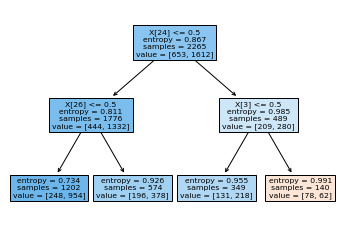

In [206]:
plt.figure()
tree.plot_tree(clf2,filled=True)  
plt.savefig('product_4_decisiontree.eps',format='eps',bbox_inches = "tight") #save trees using different groups

### Using RFM Clustering Groups for result analysis(Basket 5)

In [207]:
labelled_data = pd.read_csv("../data/RFM_group.csv")
labelled_data.head()

,Unnamed: 0,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,F_change,M_change,status
0,0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,0.0,0.0,Normal
1,1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,0.0,-1.0,Normal
2,2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,0.0,0.0,Loyal
3,3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,0.0,0.0,Loyal
4,4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,0.0,0.0,Normal


In [208]:
test_df = pd.DataFrame({'ID':X_test_id, 'true':y_test})
test_df = test_df.merge(labelled_data[['ID','status']], left_on ='ID', right_on='ID', how = 'left')
test_df.head()

,ID,true,status
0,Panel 225002101,1.0,Loyal
1,Panel 800603801,1.0,Normal
2,Panel 800305301,1.0,Loyal
3,Panel 801607501,0.0,Normal
4,Panel 109037101,1.0,Normal


In [209]:
test_df['pred']=y_pred2
test_df.head()

,ID,true,status,pred
0,Panel 225002101,1.0,Loyal,1.0
1,Panel 800603801,1.0,Normal,0.0
2,Panel 800305301,1.0,Loyal,1.0
3,Panel 801607501,0.0,Normal,1.0
4,Panel 109037101,1.0,Normal,1.0


In [210]:
for status in ["Improving","Loyal","Normal","Churning"]:
    cm2 = pd.DataFrame(confusion_matrix(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']))
    cm2.columns = ['True Y=0','True Y=1']
    cm2.index = ['Predicted Y=0','Predicted Y=1']
    display(cm2)
    print(f"Accuracy for {status}:",round(accuracy_score(test_df[test_df['status']==status]['pred'], test_df[test_df['status']==status]['true']),4))
    

,True Y=0,True Y=1
Predicted Y=0,0,1
Predicted Y=1,21,49


Accuracy for Improving: 0.6901


,True Y=0,True Y=1
Predicted Y=0,1,2
Predicted Y=1,3,160


Accuracy for Loyal: 0.9699


,True Y=0,True Y=1
Predicted Y=0,7,12
Predicted Y=1,134,341


Accuracy for Normal: 0.7045


,True Y=0,True Y=1
Predicted Y=0,3,3
Predicted Y=1,28,62


Accuracy for Churning: 0.6771


## Analysis of customer spending based on each cluster

In [211]:
temp = pd.merge(data, seg_data2, on = "Category", how = "inner")

grouped = temp.groupby(["Panel ID","Date","Category","Clusters"]).agg({'Spend': lambda x : x.sum()})

df = pd.merge(grouped.reset_index(),labelled_data, left_on = "Panel ID", right_on="ID")

avg_spend_cluster_status = df.groupby(["Clusters","status"]).agg({'Spend': lambda x : x.mean()}).reset_index()
avg_spend_cluster_status = avg_spend_cluster_status[avg_spend_cluster_status.status != "Churned"].reset_index()
#avg_spend_cluster_status.to_csv("average spending each cluster and each status.csv")

avg_spend_each_cluster = grouped.reset_index().groupby("Clusters").agg({'Spend': lambda x : x.mean()}).reset_index()
avg_spend_each_cluster

,Clusters,Spend
0,0,9.973905
1,1,20.471149
2,2,14.009075
3,3,81.839229
4,4,16.898353
5,5,9.112148


In [212]:
avg_spend_cluster_status

,index,Clusters,status,Spend
0,1,0,Churning,9.598499
1,2,0,Improving,9.438488
2,3,0,Loyal,9.728877
3,4,0,Normal,10.271496
4,6,1,Churning,18.688813
5,7,1,Improving,20.485047
6,8,1,Loyal,19.590811
7,9,1,Normal,20.952139
8,11,2,Churning,13.747502
9,12,2,Improving,14.082461


In [213]:
avg_spend_status=df.groupby("status").agg({'Spend': lambda x : x.mean()}).reset_index()
avg_spend_status = avg_spend_status[avg_spend_status.status != "Churned"].reset_index()
avg_spend_status

,index,status,Spend
0,1,Churning,10.838120
1,2,Improving,11.167419
2,3,Loyal,11.107635
3,4,Normal,11.813856


In [214]:
total_spend_status=df.groupby("status").agg({'Spend': lambda x : x.sum()}).reset_index()
total_spend_status = total_spend_status[total_spend_status.status != "Churned"].reset_index()
total_spend_status

,index,status,Spend
0,1,Churning,874950.6
1,2,Improving,571101.8
2,3,Loyal,4789545.7
3,4,Normal,6145378.8


In [215]:
#temp = pd.merge(data, seg_data2, on = "Category", how = "inner")

grouped2 = temp.groupby(["Panel ID"]).agg({'Spend': lambda x : x.sum()})

In [216]:
df2 = pd.merge(grouped2.reset_index(),labelled_data, left_on = "Panel ID", right_on="ID")

In [217]:
df2.groupby(["status"]).agg({'Spend': lambda x : x.mean()})

,Spend
status,
Churned,707.719822
Churning,3136.023656
Improving,2340.581148
Loyal,8243.624269
Normal,3651.443137
